In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
def get_full_df(npy_file):
    file = np.load(npy_file, allow_pickle=True)
    df = pd.DataFrame(file.T)
    df["iters"] = df.index + 1
    df = df[["iters"] + [col for col in df.columns if col != "iters"]]
    return df

def get_lhs_plot(lhs_df, prop_iters, cols=None, savefig=False):
    fig, ax = plt.subplots(figsize=(10,8))
    n_iters = int(prop_iters*len(lhs_df))
    if cols is None:
        cols = lhs_df.columns
    for col in cols:
        lhs_vals = lhs_df[col].to_list()
        lhs_vals = lhs_vals[:n_iters]
        ax.plot(lhs_vals, label=f"{col}", alpha=0.7)
    ax.set_yscale("log")
    ax.set_xlabel("Step", fontsize=16)
    ax.set_ylabel("Residuals ($L_1$ norm)", fontsize=16)
    ax.set_title(f"LHS during training (first {n_iters} iters)", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
#     ax.legend(fontsize=14)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
    if savefig:
        plt.savefig('lhs_plot.png', dpi=300)
    else:
        plt.show()
        
def ma_helper(lhs_vals, ma_window):
    ma = []
    for i in range(len(lhs_vals)-ma_window):
        ma.append(np.mean(lhs_vals[i:i+ma_window]))
    return ma
        
def get_lhs_ma_plot(lhs_df, prop_iters, ma_window, name='EXP', cols=None, savefig=False):
    
    plt.rc('axes', titlesize=18, labelsize=18)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rcParams['text.usetex'] = True
    
    fig, ax = plt.subplots(figsize=(8,6))
    n_iters = int(prop_iters*len(lhs_df))
    if cols is None:
        cols = lhs_df.columns
    colors = ['blue', 'crimson']
    for i, col in enumerate(cols):
        lhs_vals = lhs_df[col].to_list()
        ma_vals = ma_helper(lhs_vals[:n_iters], ma_window=ma_window)
        stop_iter = get_ma_stop_iter(lhs_vals[:n_iters], ma_window=ma_window, stop_window=n_iters, patience=20)
        ax.plot(range(ma_window, len(ma_vals)+ma_window), ma_vals, label=f"{col}", c=colors[i], alpha=0.6, zorder=1)
        print(stop_iter)
        if stop_iter != -1:
            ax.scatter(stop_iter, ma_vals[stop_iter], color='black', s=80, marker='x', zorder=2)
    ax.set_yscale("log")
    ax.set_xlabel("Step")
    ax.set_ylabel("Residuals ($L_1$ norm)")
    ax.set_title(f"Residual Moving Average ({name})")
    ax.tick_params(axis='both', which='major')
    if savefig:
        plt.savefig(name+'_lhs_plot.png', dpi=300)
    else:
        plt.show()
        
def get_lhs_var_plot(lhs_df, prop_iters, var_window, name='EXP', cols=None, savefig=False):
    
    plt.rc('axes', titlesize=18, labelsize=18)
    # plt.rc('legend', fontsize=15)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rcParams['text.usetex'] = True
    
    fig, ax = plt.subplots(figsize=(8,6))
    n_iters = int(prop_iters*len(lhs_df))
    if cols is None:
        cols = lhs_df.columns
    colors = ['tab:blue', 'tab:red']
    for i, col in enumerate(cols):
        lhs_vals = lhs_df[col].to_list()
        stop_iter = get_var_stop_iter(lhs_vals, var_window=var_window, stop_window=n_iters, patience=0.15*len(lhs_vals))
        ax.plot(lhs_vals[:n_iters], c=colors[i], label=f"{col}", alpha=0.6, zorder=1)
        print(stop_iter)
        if stop_iter != -1:
            ax.scatter(stop_iter, lhs_vals[stop_iter], color='black', s=100, linewidth=2, marker='x', zorder=2)
    ax.set_yscale("log")
    ax.set_xlabel("Step")
    ax.set_ylabel("Residuals ($L_1$ norm)")
    ax.set_title(name)
    ax.tick_params(axis='both', which='major')
    if savefig:
        plt.savefig(name+'_lhs_plot.png', dpi=300)
    else:
        plt.show()
        
def get_lhs_var_subplot(lhs_df_list, prop_iters, var_window, name_list=['EXP'], cols=None, savefig=False):
    
    plt.rc('axes', titlesize=18, labelsize=18)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rcParams['text.usetex'] = True
    
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.ravel()
    
    for i, lhs_df in enumerate(lhs_df_list):
        n_iters = int(prop_iters*len(lhs_df))
        df_cols = cols[i]
        colors = ['tab:blue', 'tab:red']
        for j, col in enumerate(df_cols):
            lhs_vals = lhs_df[col].to_list()
            stop_iter = get_var_stop_iter(lhs_vals, var_window=var_window, stop_window=n_iters, patience=0.15*len(lhs_vals))
            ax[i].plot(lhs_vals[:n_iters], c=colors[j], label=f"{col}", alpha=0.6, zorder=1)
            if stop_iter != -1:
                ax[i].scatter(stop_iter, lhs_vals[stop_iter], color='black', s=100, linewidth=2, marker='x', zorder=2)
        ax[i].set_yscale("log")
        ax[i].set_xlabel("Step")
        if i == 0:
            ax[i].set_ylabel("Residuals ($L_1$ norm)")
        ax[i].set_title(name_list[i])
        ax[i].tick_params(axis='both', which='major')
    plt.tight_layout()
    if savefig:
        plt.savefig('lhs_subplot.png', dpi=300)
    else:
        plt.show()

# 1. EXP 

## 1.1 With noise (LHS)

In [8]:
results_dir = 'C:/Users/Blake Bullwinkel/Documents/Harvard/denn/notebooks/early_abandonment/'

# read in the results tables
rand_reps = pd.read_csv(results_dir+'rand_reps_noise.csv')
rand_reps_mse = pd.read_csv(results_dir+'rand_reps_mse_noise.csv')
rand_reps_lhs = pd.read_csv(results_dir+'rand_reps_lhs_noise.csv')

In [9]:
def get_id(row):
    return f"{int(row['seed'])}_{row['g_lr']:.5f}_{row['d_lr']:.5f}"

def get_group(row):
    if row["mean_squared_error"] < 1e-12:
        return 1
    elif row["mean_squared_error"] < 1e-3:
        return 2
    else:
        return 3
    
def get_terminate(row):
    if row["group"] == 3:
        return 1
    else:
        return 0

# add column to indicate id and group number
rand_reps["id"] = rand_reps.apply(get_id, axis=1)
rand_reps["group"] = rand_reps.apply(get_group, axis=1)
rand_reps

,seed,g_lr,d_lr,mean_squared_error,id,group
0,6,0.019281,0.028710,1.265277e-08,6_0.01928_0.02871,2
1,3,0.091230,0.012388,3.152366e-16,3_0.09123_0.01239,1
2,7,0.055473,0.026329,4.940255e-14,7_0.05547_0.02633,1
3,4,0.084381,0.062474,4.940255e-14,4_0.08438_0.06247,1
4,6,0.038804,0.047928,4.043942e-15,6_0.03880_0.04793,1
...,...,...,...,...,...,...
495,0,0.028449,0.084600,3.351034e-10,0_0.02845_0.08460,2
496,6,0.036383,0.048780,6.913252e-05,6_0.03638_0.04878,2
497,6,0.090670,0.032384,3.152366e-16,6_0.09067_0.03238,1
498,8,0.011170,0.065543,1.603617e+00,8_0.01117_0.06554,3


In [10]:
# split dataframes into groups
rand_reps_group1 = rand_reps[rand_reps["group"]==1]
rand_reps_group2 = rand_reps[rand_reps["group"]==2]
rand_reps_group3 = rand_reps[rand_reps["group"]==3]

# get id's associated with each group
group1_ids = rand_reps_group1["id"].to_list()
group2_ids = rand_reps_group2["id"].to_list()
group3_ids = rand_reps_group3["id"].to_list()

In [11]:
# split LHS dataframes into groups
lhs_group1 = rand_reps_lhs[group1_ids]
lhs_group2 = rand_reps_lhs[group2_ids]
lhs_group3 = rand_reps_lhs[group3_ids]

In [12]:
def early_stop(lhs_vals, patience):    
    '''
    takes a series of LHS values and returns 1
    if trial should be abandoned early (within x% iters)
    and 0 otherwise
    '''
    n_increase = 0
    last_val = lhs_vals[0]
    n_vals = len(lhs_vals)
    
    for i, val in enumerate(lhs_vals[1:]):
        if val > last_val:
            n_increase += 1
            if n_increase == patience:
                print(f"Run terminated at iteration {i} ({100*(i/n_vals):.2f}%)")
                return 1
        else:
            n_increase = 0
        last_val = val
    print("Run completed.")
    return 0

def early_stop_ma(lhs_vals, ma_window, stop_window, patience):    
    '''
    takes a series of LHS values and returns 1
    if trial should be abandoned early (within x% iters)
    and 0 otherwise
    '''
    n_increase = 0
    last_avg = np.mean(lhs_vals[:ma_window])
    n_vals = len(lhs_vals)
    
    for i in range(1, stop_window-ma_window):
        avg = np.mean(lhs_vals[i:i+ma_window])
        if avg > last_avg:
            n_increase += 1
            if n_increase == patience:
                print(f"Run terminated at iteration {i+ma_window} ({100*((i+ma_window)/n_vals):.2f}%)")
                return 1
        else:
            n_increase = 0
        last_avg = avg
    print("Run completed.")
    return 0

def get_ma_stop_iter(lhs_vals, ma_window, stop_window, patience):    
    n_increase = 0
    last_avg = np.mean(lhs_vals[:ma_window])
    n_vals = len(lhs_vals)
    
    for i in range(1, stop_window-ma_window):
        avg = np.mean(lhs_vals[i:i+ma_window])
        if avg > last_avg:
            n_increase += 1
            if n_increase == patience:
                return i+ma_window
        else:
            n_increase = 0
        last_avg = avg
    return -1

def early_stop_var(lhs_vals, var_window, stop_window, patience):    
    n_vals = len(lhs_vals)
    for i in range(int(patience), stop_window-var_window):
        vals = lhs_vals[i:i+var_window]
        var = np.var(vals)
        if var > 0.01:
            print(f"Run terminated at iteration {i+var_window} ({100*((i+var_window)/n_vals):.2f}%)")
            return 1
    print("Run completed.")
    return 0

def get_var_stop_iter(lhs_vals, var_window, stop_window, patience):    
    n_vals = len(lhs_vals)
    for i in range(int(patience), stop_window-var_window):
        vals = lhs_vals[i:i+var_window]
        var = np.var(vals)
        if var > 0.01:
            return i+var_window
    return -1

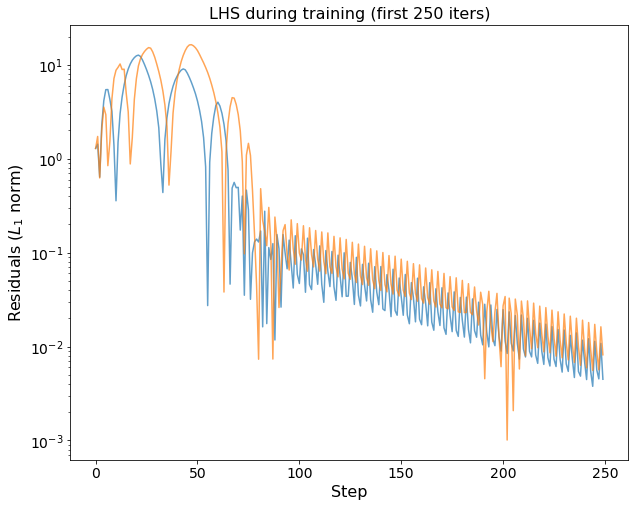

In [13]:
# plot LHS of group 1 runs
get_lhs_plot(lhs_group1, cols=group1_ids[1:3], prop_iters=0.25)

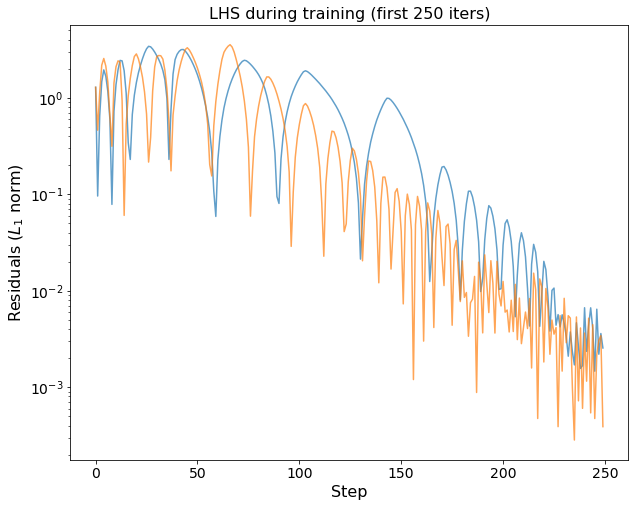

In [14]:
# plot LHS of group 2 runs
get_lhs_plot(lhs_group2, cols=group2_ids[1:3], prop_iters=0.25)

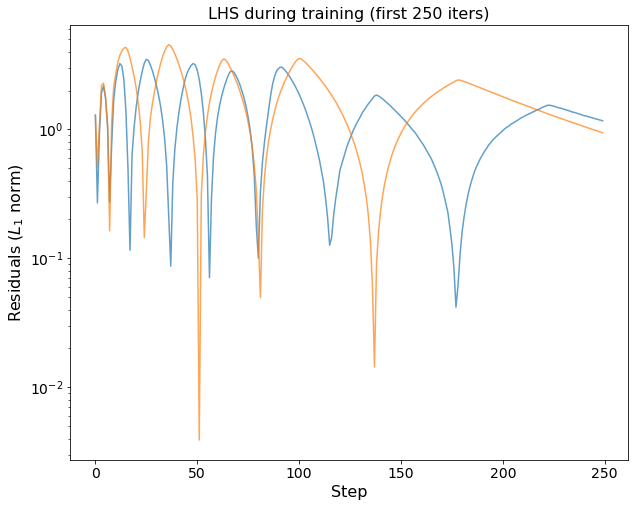

In [15]:
# plot LHS of group 3 runs
get_lhs_plot(lhs_group3, cols=group3_ids[1:3], prop_iters=0.25)

-1
170


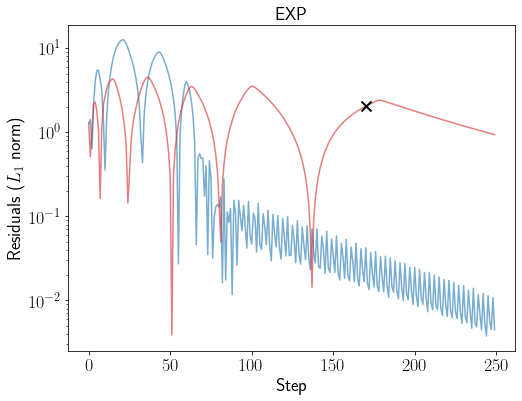

In [16]:
plot_ids = group1_ids[1:2] + group3_ids[2:3]
# get_lhs_ma_plot(rand_reps_lhs, cols=plot_ids, ma_window=5, prop_iters=0.25, savefig=False)
get_lhs_var_plot(rand_reps_lhs, cols=plot_ids, var_window=20, prop_iters=0.25, savefig=True)

In [14]:
# run early stopping algorithm on group 1
for col in lhs_group1.columns:
    lhs_vals = lhs_group1[col].to_list()
    # early_stop_ma(lhs_vals, ma_window=5, stop_window=250, patience=20)
    early_stop_var(lhs_vals, var_window=20, stop_window=250, patience=0.15*len(lhs_vals))

Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.

In [15]:
# run early stopping algorithm on group 2
for col in lhs_group2.columns:
    lhs_vals = lhs_group2[col].to_list()
    # early_stop_ma(lhs_vals, ma_window=5, stop_window=250, patience=20)
    early_stop_var(lhs_vals, var_window=20, stop_window=250, patience=0.15*len(lhs_vals))

Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 225 (22.50%)
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 192 (19.20%)
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run c

In [16]:
# run early stopping algorithm on group 3
for col in lhs_group3.columns:
    lhs_vals = lhs_group3[col].to_list()
    # early_stop_ma(lhs_vals, ma_window=5, stop_window=250, patience=20)
    early_stop_var(lhs_vals, var_window=20, stop_window=250, patience=0.15*len(lhs_vals))

Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 173 (17.30%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)
Run terminated a

In [17]:
# get early stopping indicators for all runs
terminate_list = []
for col in rand_reps_lhs.columns:
    lhs_vals = rand_reps_lhs[col].to_list()
    terminate = early_stop_var(lhs_vals, var_window=20, stop_window=250, patience=0.15*len(lhs_vals))
    # terminate = early_stop_ma(lhs_vals, ma_window=5, stop_window=250, patience=20)
    terminate_list.append(terminate)
rand_reps["terminated"] = terminate_list
rand_reps

Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at itera

Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run terminated at iteration 170 (17.00%)


,seed,g_lr,d_lr,mean_squared_error,id,group,terminated
0,6,0.019281,0.028710,1.265277e-08,6_0.01928_0.02871,2,0
1,3,0.091230,0.012388,3.152366e-16,3_0.09123_0.01239,1,0
2,7,0.055473,0.026329,4.940255e-14,7_0.05547_0.02633,1,0
3,4,0.084381,0.062474,4.940255e-14,4_0.08438_0.06247,1,0
4,6,0.038804,0.047928,4.043942e-15,6_0.03880_0.04793,1,0
...,...,...,...,...,...,...,...
495,0,0.028449,0.084600,3.351034e-10,0_0.02845_0.08460,2,1
496,6,0.036383,0.048780,6.913252e-05,6_0.03638_0.04878,2,0
497,6,0.090670,0.032384,3.152366e-16,6_0.09067_0.03238,1,0
498,8,0.011170,0.065543,1.603617e+00,8_0.01117_0.06554,3,1


In [19]:
rand_reps.to_csv("exp_terminate_noise.csv", index=False)

## 1.2 With noise (LHS+RHS)

In [27]:
results_dir = 'C:/Users/Blake Bullwinkel/Documents/Harvard/denn/notebooks/early_abandonment/'

# read in the results tables
rand_reps_doublenoise = pd.read_csv(results_dir+'rand_reps_doublenoise.csv')
rand_reps_mse_doublenoise = pd.read_csv(results_dir+'rand_reps_mse_doublenoise.csv')
rand_reps_lhs_doublenoise = pd.read_csv(results_dir+'rand_reps_lhs_doublenoise.csv')

# add column to indicate id and group number
rand_reps_doublenoise["id"] = rand_reps_doublenoise.apply(get_id, axis=1)
rand_reps_doublenoise["group"] = rand_reps_doublenoise.apply(get_group, axis=1)

# get early stopping indicators for all runs
terminate_list = []
for col in rand_reps_lhs_doublenoise.columns:
    lhs_vals = rand_reps_lhs_doublenoise[col].to_list()
    terminate = early_stop_var(lhs_vals, var_window=20, stop_window=250, patience=0.15*len(lhs_vals))
    # terminate = early_stop_ma(lhs_vals, ma_window=5, stop_window=250, patience=20)
    terminate_list.append(terminate)
rand_reps_doublenoise["terminated"] = terminate_list
rand_reps_doublenoise

Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run comp

,seed,g_lr,d_lr,mean_squared_error,id,group,terminated
0,6,0.019281,0.028710,3.786630e-08,6_0.01928_0.02871,2,0
1,3,0.091230,0.012388,3.152366e-16,3_0.09123_0.01239,1,0
2,7,0.055473,0.026329,1.289513e-14,7_0.05547_0.02633,1,0
3,4,0.084381,0.062474,3.152366e-16,4_0.08438_0.06247,1,0
4,6,0.038804,0.047928,3.152366e-16,6_0.03880_0.04793,1,0
...,...,...,...,...,...,...,...
495,0,0.028449,0.084600,1.419046e-10,0_0.02845_0.08460,2,0
496,6,0.036383,0.048780,7.625990e-12,6_0.03638_0.04878,2,0
497,6,0.090670,0.032384,4.940255e-14,6_0.09067_0.03238,1,0
498,8,0.011170,0.065543,2.867115e-01,8_0.01117_0.06554,3,1


In [28]:
rand_reps_doublenoise.to_csv("exp_terminate_doublenoise.csv", index=False)

## 1.3 No noise

In [18]:
results_dir = 'C:/Users/Blake Bullwinkel/Documents/Harvard/denn/notebooks/early_abandonment/'

# read in the results tables
rand_reps = pd.read_csv(results_dir+'rand_reps.csv')
rand_reps_mse = pd.read_csv(results_dir+'rand_reps_mse.csv')
rand_reps_lhs = pd.read_csv(results_dir+'rand_reps_lhs.csv')

# add column to indicate id and group number
rand_reps["id"] = rand_reps.apply(get_id, axis=1)
rand_reps["group"] = rand_reps.apply(get_group, axis=1)

# get early stopping indicators for all runs
terminate_list = []
for col in rand_reps_lhs.columns:
    lhs_vals = rand_reps_lhs[col].to_list()
    terminate = early_stop_var(lhs_vals, var_window=20, stop_window=250, patience=0.15*len(lhs_vals))
    # terminate = early_stop_ma(lhs_vals, ma_window=5, stop_window=250, patience=20)
    terminate_list.append(terminate)
rand_reps["terminated"] = terminate_list
rand_reps

Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run term

Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run completed.
Run completed.
Run completed.
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.
Run terminated at iteration 170 (17.00%)
Run completed.


,seed,g_lr,d_lr,mean_squared_error,id,group,terminated
0,6,0.019281,0.028710,6.877593e-09,6_0.01928_0.02871,2,0
1,3,0.091230,0.012388,3.152366e-16,3_0.09123_0.01239,1,0
2,7,0.055473,0.026329,3.152366e-16,7_0.05547_0.02633,1,0
3,4,0.084381,0.062474,4.970915e-14,4_0.08438_0.06247,1,0
4,6,0.038804,0.047928,9.151457e-15,6_0.03880_0.04793,1,0
...,...,...,...,...,...,...,...
495,0,0.028449,0.084600,2.552855e-07,0_0.02845_0.08460,2,0
496,6,0.036383,0.048780,5.262292e-12,6_0.03638_0.04878,2,1
497,6,0.090670,0.032384,3.152366e-16,6_0.09067_0.03238,1,0
498,8,0.011170,0.065543,2.395911e+00,8_0.01117_0.06554,3,1


In [22]:
rand_reps.to_csv("exp_terminate.csv", index=False)

# 2. NLO

-1
1520


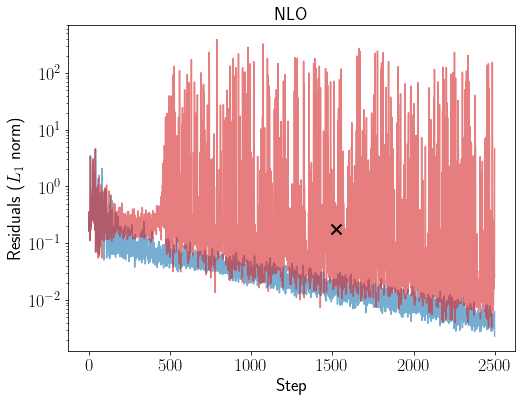

In [17]:
results_dir = 'C:/Users/Blake Bullwinkel/Documents/Harvard/denn/notebooks/rand_reps/'

nlo_lhs = get_full_df(results_dir+"rand_reps_nlo_lhs.npy")
get_lhs_var_plot(nlo_lhs, cols=[0, 6], var_window=20, prop_iters=0.25, name='NLO', savefig=True)

# 3. COO

-1
7520


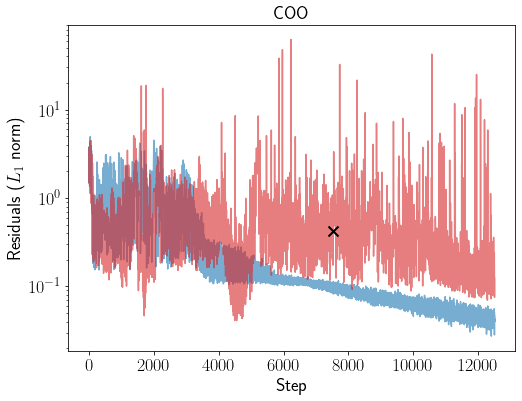

In [18]:
coo_lhs = get_full_df(results_dir+"rand_reps_coo_lhs.npy")
get_lhs_var_plot(coo_lhs, cols=[2, 0], var_window=20, prop_iters=0.25, name='COO', savefig=True)

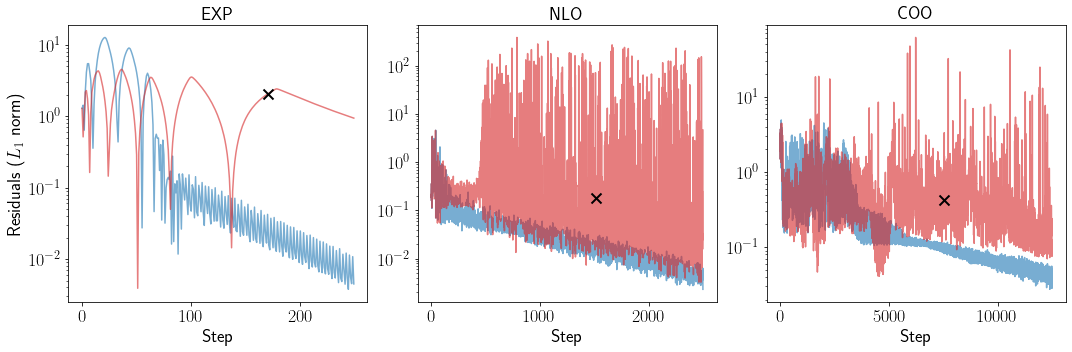

In [26]:
get_lhs_var_subplot(lhs_df_list=[rand_reps_lhs, nlo_lhs, coo_lhs], prop_iters=0.25, var_window=20, name_list=['EXP', 'NLO', 'COO'], cols=[plot_ids, [0, 6], [2, 0]], savefig=True)